## Stroboscopic plot with cubic spline interplation for Mean field 

<ipython-input-2-6bb95ab1924a>:71: ComplexWarning: Casting complex values to real discards the imaginary part
  sxx[xx] = mx_mf[math.floor((len(mx_mf)-1)/(xx * T))]
<ipython-input-2-6bb95ab1924a>:72: ComplexWarning: Casting complex values to real discards the imaginary part
  szz[xx] = mx_mf[math.floor((len(mz_mf)-1)/(xx * T))]
<ipython-input-2-6bb95ab1924a>:71: ComplexWarning: Casting complex values to real discards the imaginary part
  sxx[xx] = mx_mf[math.floor((len(mx_mf)-1)/(xx * T))]
<ipython-input-2-6bb95ab1924a>:72: ComplexWarning: Casting complex values to real discards the imaginary part
  szz[xx] = mx_mf[math.floor((len(mz_mf)-1)/(xx * T))]
<ipython-input-2-6bb95ab1924a>:71: ComplexWarning: Casting complex values to real discards the imaginary part
  sxx[xx] = mx_mf[math.floor((len(mx_mf)-1)/(xx * T))]
<ipython-input-2-6bb95ab1924a>:72: ComplexWarning: Casting complex values to real discards the imaginary part
  szz[xx] = mx_mf[math.floor((len(mz_mf)-1)/(xx * T))]


time taken 1.4860826969146728 minutes


[]

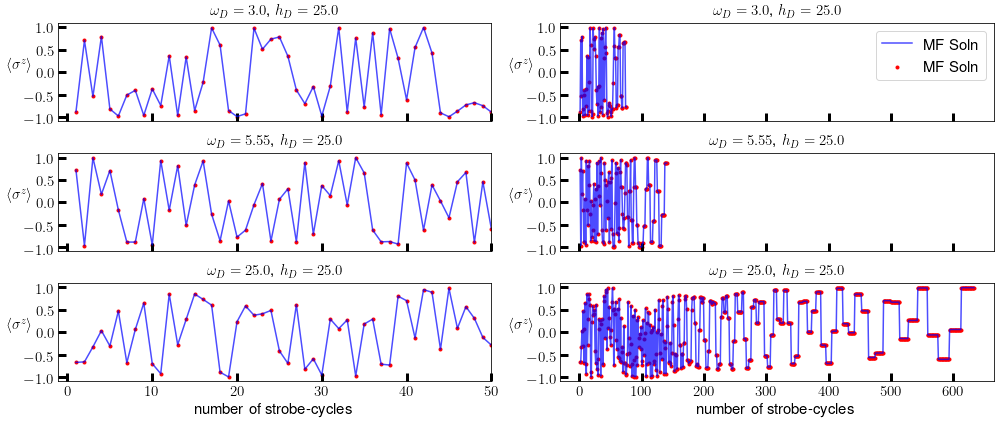

In [2]:
import numpy as np
from numpy.linalg import multi_dot, norm, eig
from odeintw import odeintw
from scipy.signal import find_peaks
import time
import math

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

fs = 15
pheightmin = 10

sx = np.array([[0, 1],[ 1, 0]])
sy = np.array([[0, -1j],[1j, 0]])
sz = np.array([[1, 0],[0, -1]])

t = np.linspace(0, 1000, 30000)
h0 = 0.1
h = 25.0                          # for number of stroning cycles
besj_zero = 2.40482555769577

omegas = [3.0, 5.55, 25.0]
fig, axs = plt.subplots(len(omegas), 2, sharex='col', figsize=(14,6))
lastplot = len(omegas) - 1

def mf_jac (psi, t, h0, h, omega):
    sx_mf = multi_dot([psi.conjugate(), sx, psi])
    drive = h0 + h * np.cos(omega * t)
    jac = (1j) * (sx_mf * sx + drive * sz)
    return jac

def mf_func (psi, t, h0, h, omega):
    return np.dot(mf_jac(psi, t, h0, h, omega), psi)

def tls_jac (psi, t, h0, h, omega):
    drive = h0 + h * np.cos(omega * t)
    jac = (1j) * 0.5 * (sx + drive * sz)
    return jac

def tls_func (psi, t, h0, h, omega):
    return np.dot(tls_jac(psi, t, h0, h, omega), psi)

#Start from the t=0 ground state
#evals, evecs = eig((1j) * tls_jac(None, 0.0, h0, h, 1.0))
#psi0 = evecs[:,np.argmin(evals)].copy()

#Start from eigenstate of sx
evals, evecs = eig((1j) * tls_jac(None, 0.0, 0.0, 0.0, 0.0))
psi0 = evecs[:,np.argmin(evals)].copy()
start = time.time()

for i, w in enumerate(omegas):
    wr = w/(2 * np.pi)     # converts omega into radian
    T = 2 * np.pi/wr       # period
    tcycl = math.floor(t[len(t)-1]/T)  # total number of time cycle
    tcl = np.arange(1,tcycl+1)
    sxx,szz = np.zeros(tcycl+1), np.zeros(tcycl+1)
    
    sol_mf = odeintw(mf_func, psi0, t, args=(h0, h, w), Dfun=mf_jac)
    #sol_tls = odeintw(tls_func, psi0, t, args=(h0, h, w), Dfun=tls_jac)
    mx_mf = np.einsum("ij,jk,ik->i", sol_mf.conjugate(), sx, sol_mf)
    mz_mf = np.einsum("ij,jk,ik->i", sol_mf.conjugate(), sz, sol_mf)
    #mx_tls = np.einsum("ij,jk,ik->i", sol_tls.conjugate(), sx, sol_tls)
    #mz_tls = np.einsum("ij,jk,ik->i", sol_tls.conjugate(), sz, sol_tls)
    
    for xx in tcl:
        sxx[xx] = mx_mf[math.floor((len(mx_mf)-1)/(xx * T))]
        szz[xx] = mx_mf[math.floor((len(mz_mf)-1)/(xx * T))]
    
    axs[i, 0].set_title(r"$\omega_D = {}$, ".format(w) + r"$h_D = {}$ ".format(h), fontsize=fs)
    axs[i, 0].plot(tcl, szz[1:len(szz)].real, 'b', label = "MF Soln", alpha=0.7)
    axs[i, 0].scatter(tcl, szz[1:len(szz)].real, label = "MF Soln", color='red', marker='.')
    axs[i, 0].set_ylabel(r'$\langle\sigma^z\rangle$',fontsize=fs, rotation=0)
    axs[i, 0].tick_params(direction='in', length=8, width=3, labelsize=fs)
    axs[i, 0].set_yticks([-1.,-0.5,0.,0.5,1.], minor=False)
    axs[i, 0].set_xlim(-1.1, 50.0)
    #axs[i, 0].set_ylim(-1.1, 1.1)
    
    axs[i, 1].set_title(r"$\omega_D = {}$, ".format(w) + r"$h_D = {}$ ".format(h), fontsize=fs)
    axs[i, 1].plot(tcl, szz[1:len(szz)].real, 'b', label = "MF Soln", alpha=0.7)
    axs[i, 1].scatter(tcl, szz[1:len(szz)].real, label = "MF Soln", color='red', marker='.')
    axs[i, 1].set_ylabel(r'$\langle\sigma^z\rangle$',fontsize=fs, rotation=0)
    axs[i, 1].tick_params(direction='in', length=8, width=3, labelsize=fs)
    axs[i, 1].set_yticks([-1.,-0.5,0.,0.5,1.], minor=False)
    #axs[i, 1].set_xlim(-1.1, 50.0)
    #axs[i, 1].set_ylim(-1.1, 1.1)
    

axs[len(omegas)-1, 0].set_xlabel('number of strobe-cycles',fontsize=fs)  
axs[len(omegas)-1, 1].set_xlabel('number of strobe-cycles',fontsize=fs)  

legend0 = axs[0, 1].legend(prop={'size': fs})

# Norm sanity check
#plt.plot(t, np.abs(sol_mf[:, 0])**2 + np.abs(sol_mf[:, 1])**2)
fig.tight_layout()
fig.savefig("stroboscopic_plot.jpeg",dpi=200)
print("time taken",(time.time()-start)/60,"minutes")
plt.plot()

# Lets introduce the spline interpolation

#### Bspline interpolation

<ipython-input-42-d2ac17040b90>:73: ComplexWarning: Casting complex values to real discards the imaginary part
  sxx[xx] = mx_mf[math.floor((len(mx_mf)-1)/(xx * T))]
<ipython-input-42-d2ac17040b90>:74: ComplexWarning: Casting complex values to real discards the imaginary part
  szz[xx] = mx_mf[math.floor((len(mz_mf)-1)/(xx * T))]
<ipython-input-42-d2ac17040b90>:73: ComplexWarning: Casting complex values to real discards the imaginary part
  sxx[xx] = mx_mf[math.floor((len(mx_mf)-1)/(xx * T))]
<ipython-input-42-d2ac17040b90>:74: ComplexWarning: Casting complex values to real discards the imaginary part
  szz[xx] = mx_mf[math.floor((len(mz_mf)-1)/(xx * T))]
<ipython-input-42-d2ac17040b90>:73: ComplexWarning: Casting complex values to real discards the imaginary part
  sxx[xx] = mx_mf[math.floor((len(mx_mf)-1)/(xx * T))]
<ipython-input-42-d2ac17040b90>:74: ComplexWarning: Casting complex values to real discards the imaginary part
  szz[xx] = mx_mf[math.floor((len(mz_mf)-1)/(xx * T))]
<ipy

time taken 2.4222716887791953 minutes


[]

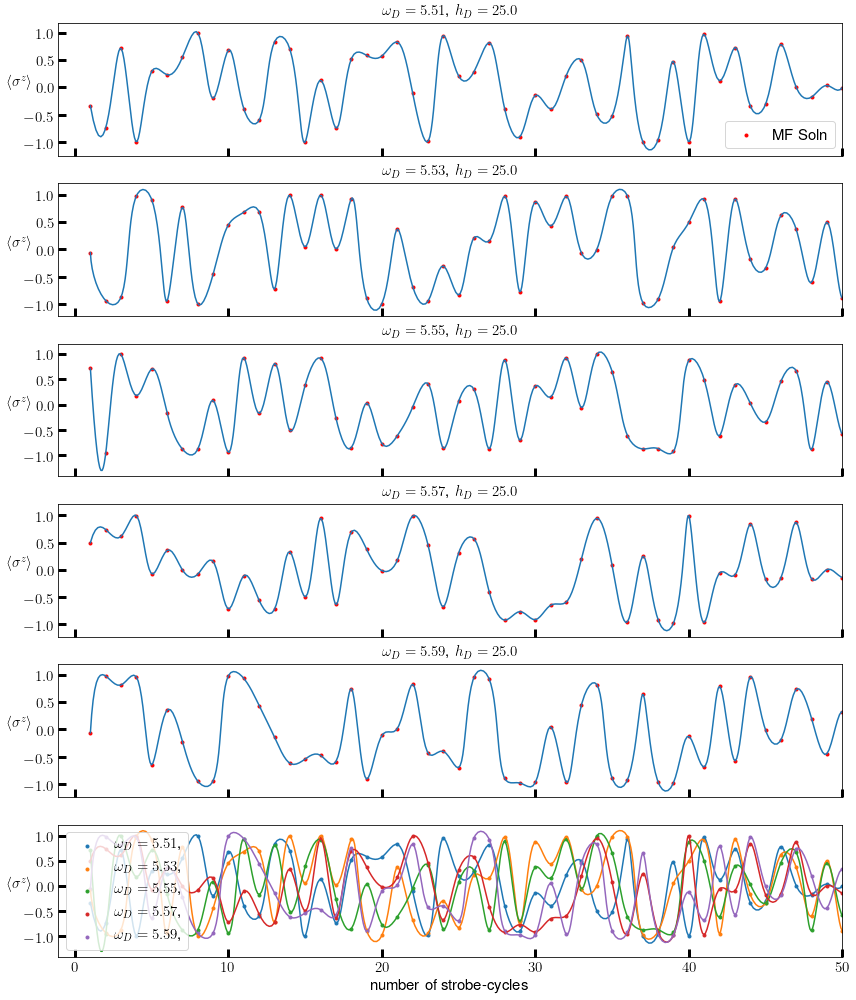

In [42]:
import numpy as np
from numpy.linalg import multi_dot, norm, eig
from odeintw import odeintw
from scipy.signal import find_peaks
import time
import math
from scipy import interpolate
from scipy.interpolate import CubicSpline

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

fs = 15
pheightmin = 10

sx = np.array([[0, 1],[ 1, 0]])
sy = np.array([[0, -1j],[1j, 0]])
sz = np.array([[1, 0],[0, -1]])

t = np.linspace(0, 1000, 30000)
h0 = 0.1
h = 25.0                          # for number of stroning cycles
besj_zero = 2.40482555769577

omegas = [5.51, 5.53, 5.55, 5.57, 5.59]
fig, axs = plt.subplots(len(omegas)+1, 1, sharex='col', figsize=(12,14))
lastplot = len(omegas)

def mf_jac (psi, t, h0, h, omega):
    sx_mf = multi_dot([psi.conjugate(), sx, psi])
    drive = h0 + h * np.cos(omega * t)
    jac = (1j) * (sx_mf * sx + drive * sz)
    return jac

def mf_func (psi, t, h0, h, omega):
    return np.dot(mf_jac(psi, t, h0, h, omega), psi)

def tls_jac (psi, t, h0, h, omega):
    drive = h0 + h * np.cos(omega * t)
    jac = (1j) * 0.5 * (sx + drive * sz)
    return jac

def tls_func (psi, t, h0, h, omega):
    return np.dot(tls_jac(psi, t, h0, h, omega), psi)

#Start from the t=0 ground state
#evals, evecs = eig((1j) * tls_jac(None, 0.0, h0, h, 1.0))
#psi0 = evecs[:,np.argmin(evals)].copy()

#Start from eigenstate of sx
evals, evecs = eig((1j) * tls_jac(None, 0.0, 0.0, 0.0, 0.0))
psi0 = evecs[:,np.argmin(evals)].copy()
start = time.time()

for i, w in enumerate(omegas):
    wr = w/(2 * np.pi)     # converts omega into radian
    T = 2 * np.pi/wr       # period
    tcycl = math.floor(t[len(t)-1]/T)  # total number of time cycle
    tcl = np.arange(1,tcycl+1)
    sxx,szz = np.zeros(tcycl+1), np.zeros(tcycl+1)
    
    sol_mf = odeintw(mf_func, psi0, t, args=(h0, h, w), Dfun=mf_jac)
    #sol_tls = odeintw(tls_func, psi0, t, args=(h0, h, w), Dfun=tls_jac)
    mx_mf = np.einsum("ij,jk,ik->i", sol_mf.conjugate(), sx, sol_mf)
    mz_mf = np.einsum("ij,jk,ik->i", sol_mf.conjugate(), sz, sol_mf)
    #mx_tls = np.einsum("ij,jk,ik->i", sol_tls.conjugate(), sx, sol_tls)
    #mz_tls = np.einsum("ij,jk,ik->i", sol_tls.conjugate(), sz, sol_tls)
    
    for xx in tcl:
        sxx[xx] = mx_mf[math.floor((len(mx_mf)-1)/(xx * T))]
        szz[xx] = mx_mf[math.floor((len(mz_mf)-1)/(xx * T))]
    data = np.array([tcl,szz[1:len(szz)]])
    #print(data)
    tck,u = interpolate.splprep(data, s=0)
    unew = np.arange(0, 1.0, .001)
    out = interpolate.splev(unew, tck)
    
    axs[i].set_title(r"$\omega_D = {}$, ".format(w) + r"$h_D = {}$ ".format(h), fontsize=fs)
    #axs[i].plot(tcl, szz[1:len(szz)].real, 'b', label = "MF Soln", alpha=0.7)
    axs[i].scatter(tcl, szz[1:len(szz)].real, label = "MF Soln", color='red', marker='.')
    axs[i].plot(out[0],out[1])
    axs[i].set_ylabel(r'$\langle\sigma^z\rangle$',fontsize=fs, rotation=0)
    axs[i].tick_params(direction='in', length=8, width=3, labelsize=fs)
    axs[i].set_yticks([-1.,-0.5,0.,0.5,1.], minor=False)
    axs[i].set_xlim(-1.1, 50.0)
    #axs[i].set_ylim(-1.1, 1.1)
    
    axs[lastplot].scatter(tcl, szz[1:len(szz)].real, label = r"$\omega_D = {}$, ".format(w), marker='.')
    axs[lastplot].plot(out[0],out[1])
    axs[lastplot].set_ylabel(r'$\langle\sigma^z\rangle$',fontsize=fs, rotation=0)
    axs[lastplot].tick_params(direction='in', length=8, width=3, labelsize=fs)
    axs[lastplot].set_yticks([-1.,-0.5,0.,0.5,1.], minor=False)
    axs[lastplot].set_xlim(-1.1, 50.0)
    
axs[lastplot].set_xlabel('number of strobe-cycles',fontsize=fs)   
legend0 = axs[0].legend(prop={'size': fs})
legend1 = axs[lastplot].legend(prop={'size': fs})
# Norm sanity check
#plt.plot(t, np.abs(sol_mf[:, 0])**2 + np.abs(sol_mf[:, 1])**2)
fig.tight_layout()
fig.savefig("stroboscopic_Bspline_plot.jpeg",dpi=300)
print("time taken",(time.time()-start)/60,"minutes")
plt.plot()

#### Cubic Spline 

time taken 2.1964140137036643 minutes


[]

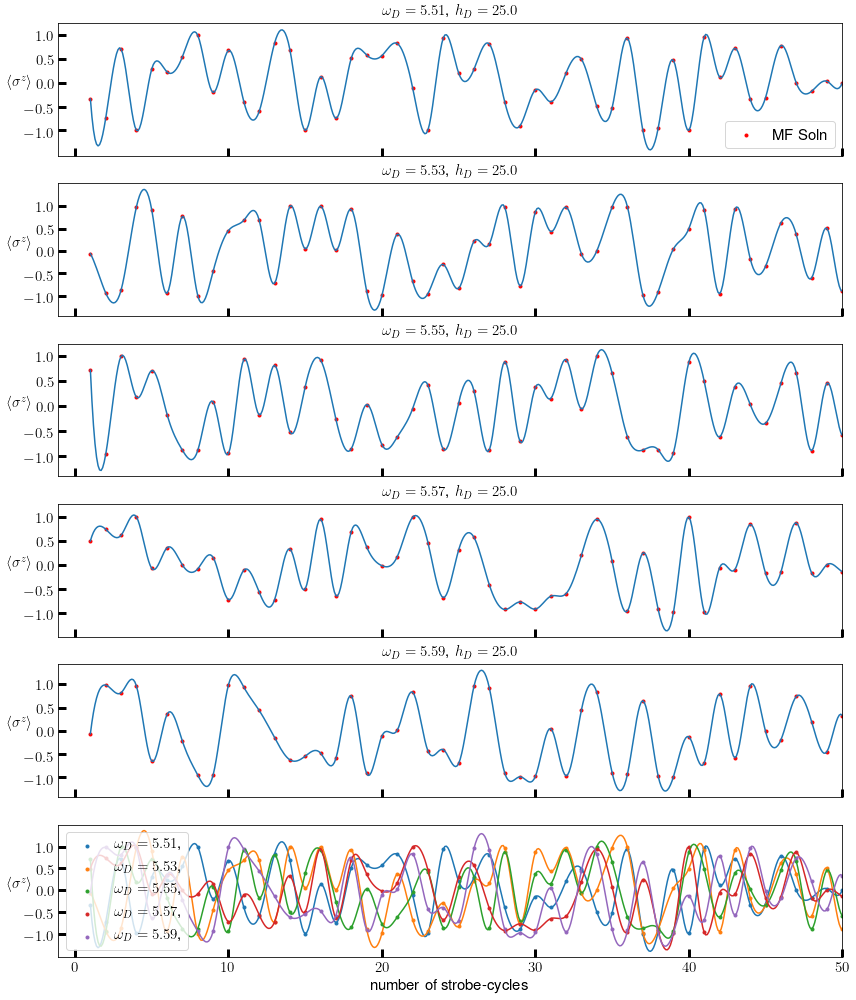

In [48]:
import numpy as np
from numpy.linalg import multi_dot, norm, eig
from odeintw import odeintw
from scipy.signal import find_peaks
import time
import math
from scipy import interpolate
from scipy.interpolate import CubicSpline

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

fs = 15
pheightmin = 10

sx = np.array([[0, 1],[ 1, 0]])
sy = np.array([[0, -1j],[1j, 0]])
sz = np.array([[1, 0],[0, -1]])

t = np.linspace(0, 1000, 30000)
h0 = 0.1
h = 25.0                          # for number of stroning cycles
besj_zero = 2.40482555769577

omegas = [5.51, 5.53, 5.55, 5.57, 5.59]
fig, axs = plt.subplots(len(omegas)+1, 1, sharex='col', figsize=(12,14))
lastplot = len(omegas)

def mf_jac (psi, t, h0, h, omega):
    sx_mf = multi_dot([psi.conjugate(), sx, psi])
    drive = h0 + h * np.cos(omega * t)
    jac = (1j) * (sx_mf * sx + drive * sz)
    return jac

def mf_func (psi, t, h0, h, omega):
    return np.dot(mf_jac(psi, t, h0, h, omega), psi)

def tls_jac (psi, t, h0, h, omega):
    drive = h0 + h * np.cos(omega * t)
    jac = (1j) * 0.5 * (sx + drive * sz)
    return jac

def tls_func (psi, t, h0, h, omega):
    return np.dot(tls_jac(psi, t, h0, h, omega), psi)

#Start from the t=0 ground state
#evals, evecs = eig((1j) * tls_jac(None, 0.0, h0, h, 1.0))
#psi0 = evecs[:,np.argmin(evals)].copy()

#Start from eigenstate of sx
evals, evecs = eig((1j) * tls_jac(None, 0.0, 0.0, 0.0, 0.0))
psi0 = evecs[:,np.argmin(evals)].copy()
start = time.time()

for i, w in enumerate(omegas):
    wr = w/(2 * np.pi)     # converts omega into radian
    T = 2 * np.pi/wr       # period
    tcycl = math.floor(t[len(t)-1]/T)  # total number of time cycle
    tcl = np.arange(1,tcycl+1)
    sxx,szz = np.zeros(tcycl+1), np.zeros(tcycl+1)
    
    sol_mf = odeintw(mf_func, psi0, t, args=(h0, h, w), Dfun=mf_jac)
    #sol_tls = odeintw(tls_func, psi0, t, args=(h0, h, w), Dfun=tls_jac)
    mx_mf = np.einsum("ij,jk,ik->i", sol_mf.conjugate(), sx, sol_mf)
    mz_mf = np.einsum("ij,jk,ik->i", sol_mf.conjugate(), sz, sol_mf)
    #mx_tls = np.einsum("ij,jk,ik->i", sol_tls.conjugate(), sx, sol_tls)
    #mz_tls = np.einsum("ij,jk,ik->i", sol_tls.conjugate(), sz, sol_tls)
    
    for xx in tcl:
        #sxx[xx] = mx_mf[math.floor((len(mx_mf)-1)/(xx * T))].real
        szz[xx] = mx_mf[math.floor((len(mz_mf)-1)/(xx * T))].real
    data = np.array([tcl,szz[1:len(szz)]])
    #print(data)
    cs = CubicSpline(tcl,szz[1:len(szz)])
    xs = np.arange(1, 100, 0.1)
    
    axs[i].set_title(r"$\omega_D = {}$, ".format(w) + r"$h_D = {}$ ".format(h), fontsize=fs)
    #axs[i].plot(tcl, szz[1:len(szz)].real, 'b', label = "MF Soln", alpha=0.7)
    axs[i].scatter(tcl, szz[1:len(szz)].real, label = "MF Soln", color='red', marker='.')
    axs[i].plot(xs, cs(xs))
    axs[i].set_ylabel(r'$\langle\sigma^z\rangle$',fontsize=fs, rotation=0)
    axs[i].tick_params(direction='in', length=8, width=3, labelsize=fs)
    axs[i].set_yticks([-1.,-0.5,0.,0.5,1.], minor=False)
    axs[i].set_xlim(-1.1, 50.0)
    #axs[i].set_ylim(-1.1, 1.1)
    
    axs[lastplot].scatter(tcl, szz[1:len(szz)], label = r"$\omega_D = {}$, ".format(w), marker='.')
    axs[lastplot].plot(xs, cs(xs))
    axs[lastplot].set_ylabel(r'$\langle\sigma^z\rangle$',fontsize=fs, rotation=0)
    axs[lastplot].tick_params(direction='in', length=8, width=3, labelsize=fs)
    axs[lastplot].set_yticks([-1.,-0.5,0.,0.5,1.], minor=False)
    axs[lastplot].set_xlim(-1.1, 50.0)
    
axs[lastplot].set_xlabel('number of strobe-cycles',fontsize=fs)   
legend0 = axs[0].legend(prop={'size': fs})
legend1 = axs[lastplot].legend(prop={'size': fs})
# Norm sanity check
#plt.plot(t, np.abs(sol_mf[:, 0])**2 + np.abs(sol_mf[:, 1])**2)
fig.tight_layout()
fig.savefig("stroboscopic_cubicSpline_plot.jpeg",dpi=300)
print("time taken",(time.time()-start)/60,"minutes")
plt.plot()